In [ ]:
#Importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from glob import glob
from tqdm.notebook import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Concatenate, BatchNormalization, Activation, MaxPool2D
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from tensorflow.keras import Model, Input
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, recall_score, precision_score
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
#Defining Image Height and Width
H=128
W=128

In [ ]:
#Creating a directory
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
#Function to load and split the dataset
def load_data(dataset_path, split=0.2):
    images = sorted(glob(os.path.join(dataset_path, "ISIC2018_Task1-2_Training_Input", "*.jpg")))
    masks = sorted(glob(os.path.join(dataset_path, "ISIC2018_Task1_Training_GroundTruth", "*.png")))

    test_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=test_size, random_state = 42)
    train_y, valid_y = train_test_split(masks, test_size=test_size, random_state = 42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state = 42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state = 42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [ ]:
#Functions to preprocess images and masks
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

In [ ]:
#Function to apply data augmentation
def apply_augmentation(image, mask):
    
    """ Random horizontal flip """
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    
    """ Random vertical flip """
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)
    
    """ Random rotation (90, 180, or 270 degrees) """
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    if k > 0:
        image = tf.image.rot90(image, k=k)
        mask = tf.image.rot90(mask, k=k)
    
    """ Random brightness adjustment """
    image = tf.image.random_brightness(image, max_delta=0.1)
    
    """ Random contrast adjustment """
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    
    image = tf.clip_by_value(image, 0.0, 1.0)
    
    return image, mask

In [ ]:
#Function to parse images and masks
def tf_parse(x, y, is_train=False):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x ,y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])

    if is_train:
        x, y = apply_augmentation(x, y)
    return x, y

In [ ]:
#Function to create tensorflow dataset
def tf_dataset(X, Y, batch_size, is_train=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(lambda x, y: tf_parse(x, y, is_train))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(10)
    return dataset

In [ ]:
#Define Convolution blocks
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding= 'same')(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding= 'same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

#Encoder block for U-Net
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

#Decoder block for U-Net
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build U-Net architecture
def build_unet(input_shape):
    inputs = Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    """ Bridge """
    b1 = conv_block(p4, 1024)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    """ Outputs """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    """ Model """
    model = Model(inputs, outputs)
    return model

In [ ]:
#Function to calculate Dice Coefficient
def dice_coef(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

#Function to calculate Intersection over Union
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis = -1)
    union = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis =-1)
    jac = (intersection + smooth) / (union - intersection + smooth)
    return jac

In [ ]:
#Function to train U-Net model
def train_model(dataset_path, batch_size=16, lr=0.001, num_epochs=10, model_path="/kaggle/working/model.keras", csv_path="/kaggle/working/data.csv"):
    """seeding"""
    np.random.seed(42)
    tf.random.set_seed(42)

    create_dir("files")

    """ Dataset : 60/20/20 """
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(dataset_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")
    print(f"Test: {len(test_x)} - {len(test_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch_size, is_train=True)
    valid_dataset = tf_dataset(valid_x, valid_y, batch_size, is_train=False)

    train_steps = (len(train_x) + batch_size - 1) // batch_size
    valid_steps = (len(valid_x) + batch_size - 1) // batch_size

    """ Model """
    model = build_unet((H, W, 3))
    metrics = [dice_coef, iou, Recall(), Precision()]
    model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=lr), metrics=metrics)
    model.summary()

    callbacks =[
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience =5, min_lr = 1e-7, verbose=1),
        CSVLogger(csv_path),
        TensorBoard(log_dir="./log"),
        EarlyStopping(monitor='val_loss', patience = 20, restore_best_weights=False)   
]

    model.fit(
        train_dataset,
        epochs = num_epochs,
        validation_data = valid_dataset,
        steps_per_epoch = train_steps,
        validation_steps = valid_steps,
        callbacks = callbacks,
        verbose=1,
        shuffle=True
    )

print("Training complete")

Training complete


In [ ]:
#Function to read and preprocess an image for evaluation
def read_image_eval(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    ori_x = x 
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)
    return ori_x, x

#Function to read and preprocess a mask for evaluation
def read_mask_eval(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.int32)
    return ori_x, x

In [ ]:
#Function to save original image, ground truth mask, and predicted mask
def save_results(ori_x, ori_y, y_pred, save_image_path):
    line = np.ones((H, 10 ,3)) * 255

    ori_y = np.expand_dims(ori_y, axis=-1)
    ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)

    cat_images = np.concatenate([ori_x, line, ori_y, line, y_pred*255], axis=1)
    cv2.imwrite(save_image_path, cat_images)

In [ ]:
#Function to evaluated the model on test data
def evaluate_model(dataset_path, model_path="/kaggle/working/model.keras"):
    """ seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Folder for saving results """
    create_dir("results")

    """ Load the model """
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef}):
        model = tf.keras.models.load_model(model_path)

    """ Load the test data """
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(dataset_path)

    SCORE=[]

    for x, y in tqdm(zip(test_x, test_y), total=len(test_x), desc="Evaluating test data"):
        """ Extracting the image name """
        name = x.split("/")[-1]

        """ Read the image and mask """
        ori_x, x = read_image_eval(x)
        ori_y, y = read_mask_eval(y)

        """ Predicting the mask """
        y_pred = model.predict(x)[0] > 0.5
        y_pred = np.squeeze(y_pred, axis=
                            -1)
        y_pred = y_pred.astype(np.int32)

        """ Saving the predicted mask """
        save_image_path = f"result/{name}"
        save_results(ori_x, ori_y, y_pred, save_image_path)

        """ Flatten the array"""
        y = y.flatten()
        y_pred = y_pred.flatten()

        """ Calculation of metrics values """
        acc_value = accuracy_score(y, y_pred)
        f1_value = f1_score(y, y_pred, labels=[0,1], average="binary")
        jac_value = jaccard_score(y, y_pred, labels=[0,1], average="binary")
        recall_value = recall_score(y, y_pred, labels=[0,1], average="binary")
        precision_value = precision_score(y, y_pred, labels=[0,1], average="binary")
        SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

    """ Compute mean of metrics values """
    score = [s[1:] for s in SCORE]
    score = np.mean(score, axis=0)
    print(f"Accuracy: {score[0]:0.5f}")
    print(f"F1: {score[1]:0.5f}")
    print(f"Jaccard: {score[2]:0.5f}")
    print(f"Recall: {score[3]:0.5f}")
    print(f"Precision: {score[4]:0.5f}")

    """ Save results to csv """
    df = pd.DataFrame(SCORE, columns=["Image Name", "Accuracy", "F1 Score", "Jaccard", "Recall", "Precision"])
    df.to_csv("files/score.csv")

In [ ]:
#Train the model
dataset_path="/kaggle/input/isic2018-challenge-task1-data-segmentation/"
train_model(dataset_path, batch_size=16, lr=0.001, num_epochs=10)

Train: 1558 - 1558
Valid: 518 - 518
Test: 518 - 518


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 64, 64, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_coef: 0.4564 - iou: 0.9986 - loss: 0.4633 - precision: 0.5650 - recall: 0.5565
Epoch 1: val_loss improved from inf to 2.60902, saving model to /kaggle/working/model.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 367s 3s/step - dice_coef: 0.4568 - iou: 0.9986 - loss: 0.4624 - precision: 0.5660 - recall: 0.5563 - val_dice_coef: 0.4147 - val_iou: 0.9955 - val_loss: 2.6090 - val_precision: 0.2845 - val_recall: 0.9046 - learning_rate: 0.0010
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - dice_coef: 0.0000e+00 - iou: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_coef: 0.5505 - iou: 0.9991 - loss: 0.3210 - precision: 0.7436 - recall: 0.6198
Epoch 3: val_loss improved from 2.60902 to 1.15985, saving model to /kaggle/working/model.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 278s 3s/step - dice_coef: 0.5509 - iou: 0.9991 - loss: 0.3207 - precision: 0.

In [ ]:
#Evaluate the model
evaluate_model(dataset_path)

Evaluating test data:   0%|          | 0/518 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━

In [ ]:
#Function to visualize random samples
def visualize_random_samples(dataset_path, model_path="/kaggle/working/model.keras", num_samples=10, save_dir="/kaggle/working/comparisons"):
    create_dir(save_dir)

    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef}):
        model = tf.keras.models.load_model(model_path)

    _, _, (x_test, y_test) = load_data(dataset_path)

    total_samples = len(x_test)
    random_indices = np.random.choice(total_samples, min(num_samples, total_samples), replace=False)

    fig = plt.figure(figsize=(15, 4 * num_samples))
    fig.suptitle('Comparison of Original, Ground Truth and Predicted segmentation', fontsize=16)

    for idx, sample_idx in enumerate(random_indices):
        image_path = x_test[sample_idx]
        mask_path = y_test[sample_idx]

        ori_x, x = read_image_eval(image_path)
        ori_y, y = read_mask_eval(mask_path)

        """ Predict mask """
        prediction = model.predict(x)[0] > 0.5
        prediction = np.squeeze(prediction, axis=-1)
        prediction = (prediction * 255).astype(np.uint8)

        """ Calculate metrics using the existing metrics functions """
        y_flat = y.flatten()
        pred_flat = prediction.flatten() / 255
        
        acc_value = accuracy_score(y_flat, pred_flat)
        f1_value = f1_score(y_flat, pred_flat, labels=[0,1], average="binary")
        jac_value = jaccard_score(y_flat, pred_flat, labels=[0,1], average="binary")

        """ Original image (convert from BGR to RGB for matplotlib) """
        ori_x_rgb = cv2.cvtColor(ori_x, cv2.COLOR_BGR2RGB)
        
        """ Plot original image """
        plt.subplot(num_samples, 3, idx * 3 + 1)
        plt.imshow(ori_x_rgb)
        plt.title('Original Image')
        plt.axis('off')
        
        """ Plot ground truth mask """
        plt.subplot(num_samples, 3, idx * 3 + 2)
        plt.imshow(ori_y, cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        """ Plot predicted mask """
        plt.subplot(num_samples, 3, idx * 3 + 3)
        plt.imshow(prediction, cmap='gray')
        plt.title(f'Predicted Mask\nDice: {f1_value:.3f}, IOU: {jac_value:.3f}')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'random_samples_comparison.png'))
    plt.close()

In [ ]:
visualize_random_samples(dataset_path, num_samples=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


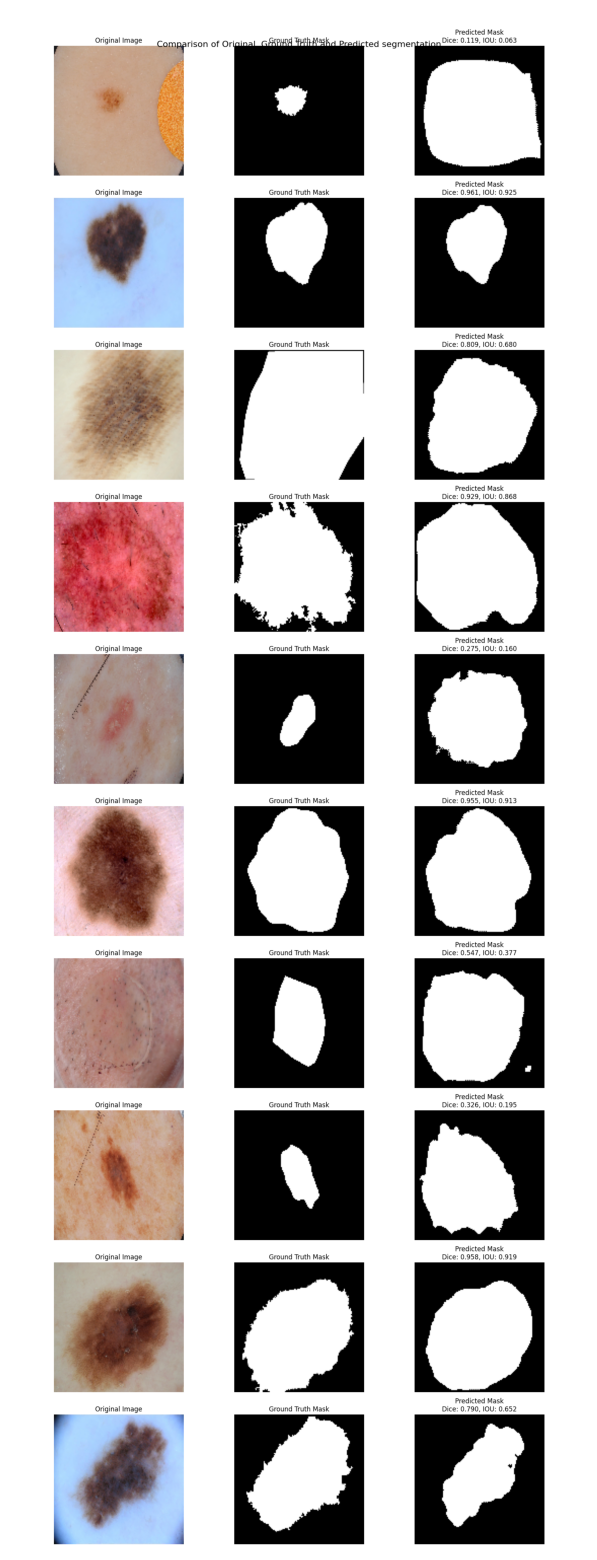

In [ ]:
#Display the comparison image
image_path = "/kaggle/working/comparisons/random_samples_comparison.png"
image = Image.open(image_path)

plt.figure(figsize=(30,20))
plt.imshow(image)
plt.axis("off")
plt.show()

In [20]:
#Try Implementation of 
#ResUNet
#Attention Gates
#CRF